<a href="https://colab.research.google.com/github/HarshithDevX/2420080016_ML/blob/main/2420080016_week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Digits dataset loaded. Training with Random Forest and AdaBoost...
Training samples: 1437, Test samples: 360

PART A: RANDOM FOREST
Best RF params: {'max_depth': 10, 'n_estimators': 200}
RF Accuracy: 0.9722, OOB Error: 0.0278
RF Train time: 0.905s, Predict time: 0.023s

PART B: ADABOOST
Best AdaBoost params: {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost Accuracy: 0.8639
AdaBoost Train time: 0.890s, Predict time: 0.050s


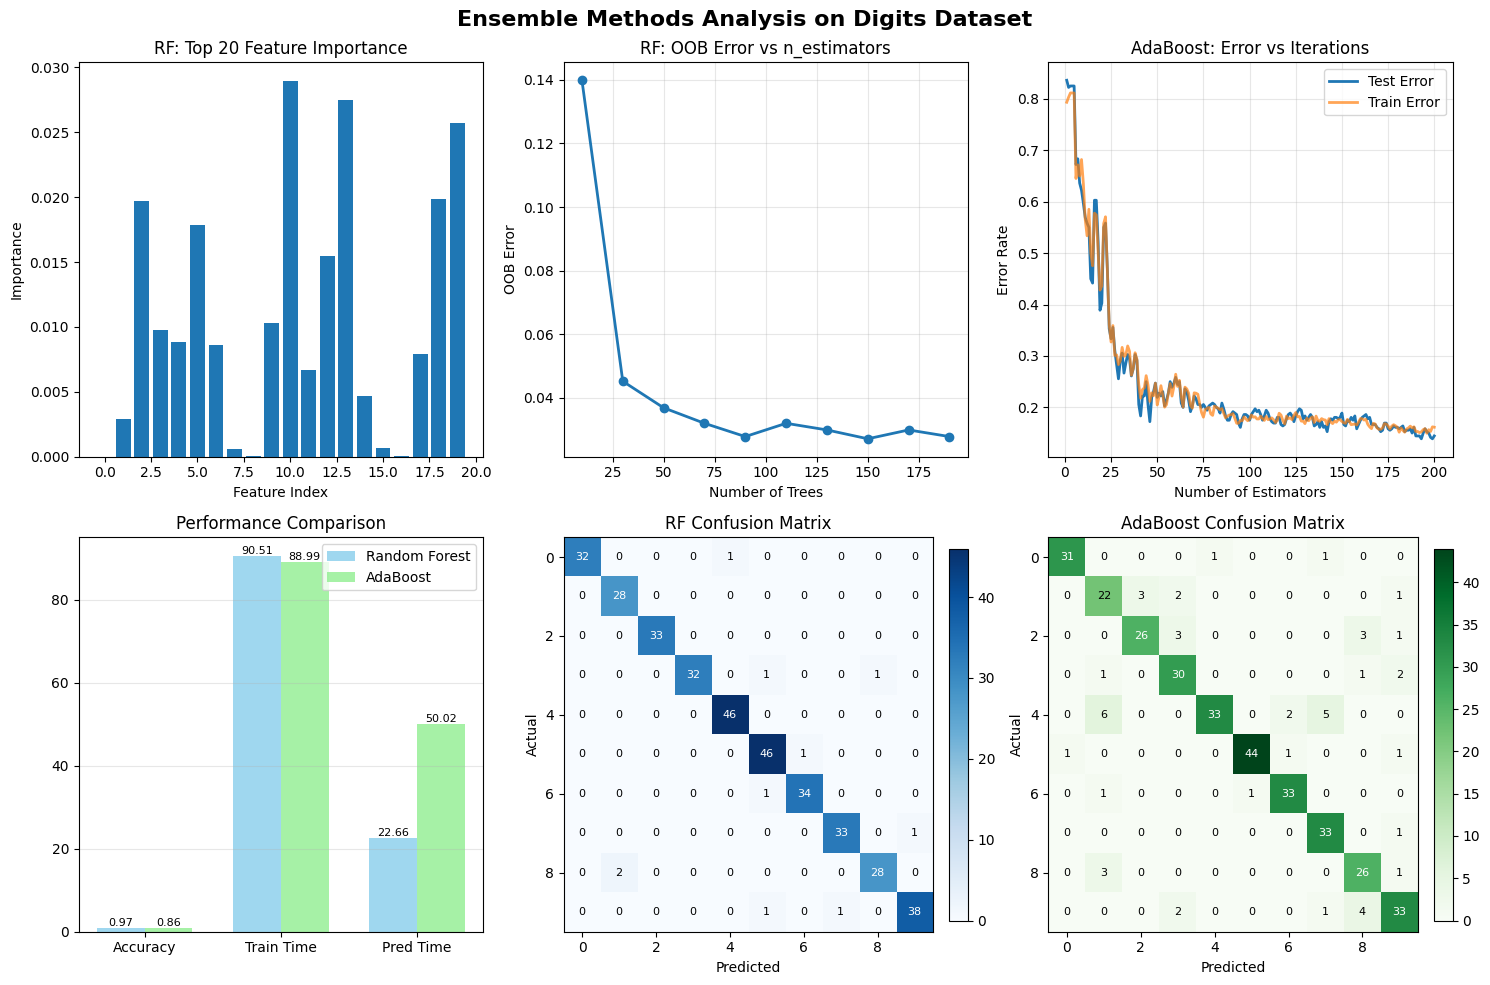


COMPARISON TABLE
Metric                    Random Forest        AdaBoost            
------------------------------------------------------------
Accuracy                  0.9722               0.8639              
Training Time (s)         0.905                0.890               
Prediction Time (ms)      22.66                50.02               
OOB/Test Error            0.0278               0.1361              
Best n_estimators         200                  200                 
Max Depth                 10                   1                   
------------------------------------------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import warnings

warnings.filterwarnings('ignore')

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Digits dataset loaded. Training with Random Forest and AdaBoost...")
print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

print("\n" + "="*50 + "\nPART A: RANDOM FOREST\n" + "="*50)

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=42),
    rf_params,
    cv=3,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

rf = rf_grid.best_estimator_
start_time = time.time()
rf.fit(X_train, y_train)
rf_train_time = time.time() - start_time

start_time = time.time()
y_pred_rf = rf.predict(X_test)
rf_pred_time = time.time() - start_time

rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Best RF params: {rf_grid.best_params_}")
print(f"RF Accuracy: {rf_accuracy:.4f}, OOB Error: {1-rf.oob_score_:.4f}")
print(f"RF Train time: {rf_train_time:.3f}s, Predict time: {rf_pred_time:.3f}s")


print("\n" + "="*50 + "\nPART B: ADABOOST\n" + "="*50)

base_dt = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

ada_grid = GridSearchCV(
    AdaBoostClassifier(estimator=base_dt, random_state=42),
    ada_params,
    cv=3,
    n_jobs=-1
)

ada_grid.fit(X_train, y_train)

ada = ada_grid.best_estimator_
start_time = time.time()
ada.fit(X_train, y_train)
ada_train_time = time.time() - start_time

start_time = time.time()
y_pred_ada = ada.predict(X_test)
ada_pred_time = time.time() - start_time

ada_accuracy = accuracy_score(y_test, y_pred_ada)

print(f"Best AdaBoost params: {ada_grid.best_params_}")
print(f"AdaBoost Accuracy: {ada_accuracy:.4f}")
print(f"AdaBoost Train time: {ada_train_time:.3f}s, Predict time: {ada_pred_time:.3f}s")


fig, axes = plt.subplots(2, 3, figsize=(15, 10))


axes[0, 0].bar(range(20), rf.feature_importances_[:20])
axes[0, 0].set_title('RF: Top 20 Feature Importance')
axes[0, 0].set_xlabel('Feature Index')
axes[0, 0].set_ylabel('Importance')


oob_errors = []

for n in range(10, 201, 20):
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    oob_errors.append(1 - rf_temp.oob_score_)

axes[0, 1].plot(range(10, 201, 20), oob_errors, 'o-', linewidth=2, markersize=6)
axes[0, 1].set_title('RF: OOB Error vs n_estimators')
axes[0, 1].set_xlabel('Number of Trees')
axes[0, 1].set_ylabel('OOB Error')
axes[0, 1].grid(True, alpha=0.3)
test_errors = []
train_errors = []

ada_temp = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada_temp.fit(X_train, y_train)

for y_pred in ada_temp.staged_predict(X_test):
    test_errors.append(1 - accuracy_score(y_test, y_pred))

for y_pred in ada_temp.staged_predict(X_train):
    train_errors.append(1 - accuracy_score(y_train, y_pred))


axes[0, 2].plot(range(1, 201), test_errors, label='Test Error', linewidth=2)
axes[0, 2].plot(range(1, 201), train_errors, label='Train Error', linewidth=2, alpha=0.7)

axes[0, 2].set_title('AdaBoost: Error vs Iterations')
axes[0, 2].set_xlabel('Number of Estimators')
axes[0, 2].set_ylabel('Error Rate')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)


metrics = ['Accuracy', 'Train Time', 'Pred Time']

rf_vals = [rf_accuracy, rf_train_time * 100, rf_pred_time * 1000]
ada_vals = [ada_accuracy, ada_train_time * 100, ada_pred_time * 1000]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, rf_vals, width,
                       label='Random Forest', color='skyblue', alpha=0.8)

bars2 = axes[1, 0].bar(x + width/2, ada_vals, width,
                       label='AdaBoost', color='lightgreen', alpha=0.8)

axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(metrics)
axes[1, 0].set_title('Performance Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')


for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(
            bar.get_x() + bar.get_width()/2.,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=8
        )
cm_rf = confusion_matrix(y_test, y_pred_rf)

im1 = axes[1, 1].imshow(cm_rf, cmap='Blues', aspect='auto')
axes[1, 1].set_title('RF Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.colorbar(im1, ax=axes[1, 1], fraction=0.046, pad=0.04)


for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        axes[1, 1].text(
            j, i, cm_rf[i, j],
            ha='center',
            va='center',
            color='white' if cm_rf[i, j] > cm_rf.max()/2 else 'black',
            fontsize=8
        )


cm_ada = confusion_matrix(y_test, y_pred_ada)

im2 = axes[1, 2].imshow(cm_ada, cmap='Greens', aspect='auto')
axes[1, 2].set_title('AdaBoost Confusion Matrix')
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')

plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)


for i in range(cm_ada.shape[0]):
    for j in range(cm_ada.shape[1]):
        axes[1, 2].text(
            j, i, cm_ada[i, j],
            ha='center',
            va='center',
            color='white' if cm_ada[i, j] > cm_ada.max()/2 else 'black',
            fontsize=8
        )


plt.suptitle('Ensemble Methods Analysis on Digits Dataset',
             fontsize=16,
             fontweight='bold')

plt.tight_layout()
plt.show()


print("\n" + "="*60 + "\nCOMPARISON TABLE\n" + "="*60)

print(f"{'Metric':<25} {'Random Forest':<20} {'AdaBoost':<20}")
print("-" * 60)

print(f"{'Accuracy':<25} {rf_accuracy:<20.4f} {ada_accuracy:<20.4f}")
print(f"{'Training Time (s)':<25} {rf_train_time:<20.3f} {ada_train_time:<20.3f}")
print(f"{'Prediction Time (ms)':<25} {rf_pred_time*1000:<20.2f} {ada_pred_time*1000:<20.2f}")
print(f"{'OOB/Test Error':<25} {1-rf.oob_score_:<20.4f} {1-ada_accuracy:<20.4f}")
print(f"{'Best n_estimators':<25} {rf.n_estimators:<20} {ada.n_estimators:<20}")

if hasattr(rf, 'max_depth'):
    print(f"{'Max Depth':<25} {rf.max_depth if rf.max_depth else 'None':<20} {ada.estimator.max_depth:<20}")

print("-" * 60)
